In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
from collections import Counter
%matplotlib inline

In [2]:
%run ./functions.py

In [3]:
def InitSettings():
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.02
    param['max_depth'] = 5
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = 21
    param['nthread'] = 8
    param['lambda']=1.0
    param ['alpha']=0.0 #[default=0]


    maxstat={}
    maxstat["manager_id"]=30
    maxstat["building_id"]=30
    maxstat["street_address"]=30

    howtouseID={} # 0= H-M-L fractions 1 columns with 0-1 ,2 =nothing

    howtouseID['manager_id']=0
    howtouseID['building_id']=0
    howtouseID['street_address']=0





    columns_for_remove=["photos",
                   "description",
                   "interest_level", "created",#"manager_id",
                   #"building_id",
                    "display_address", "street_address",#'time','listing_id',
                    'street_address_new', 'building_id_new',
                    'street_address_new_new','pred0_low','low','pred0_medium','medium','pred0_high','high',]
    others=dict()
    others["countvectorizer_max_features"]=50
    others["num_rounds"]=30
    others["withrest"]=True
    others["addlabelsasint"]=False
    others["clean_street_building_ids"]=0
    others["cut_on_cleaning_feauters"]=-1.0
    others["cut_to_divide_on_building_id"]=-1
    others["cut_lan_log_selection"]=0.0002
    others['binsize']=-1.0

    alllparams=dict()
    alllparams['xgb']=param
    alllparams['maxstat']=maxstat
    alllparams['howtouseID']=howtouseID
    alllparams['others']=others
    alllparams['columns_for_remove']=columns_for_remove
    return alllparams

In [4]:
allparams=InitSettings()
allparams=ReadIn("testTF.txt",allparams)
df_train,df_test=LoadData('fract0_15rs0',allparams)
remove_columns(df_train,allparams['columns_for_remove'])
remove_columns(df_test,allparams['columns_for_remove'])

Starting transformations
Normalizing high cordiality data...
manager_id_mean_low
manager_id_mean_medium
manager_id_mean_high
building_id_mean_low
building_id_mean_medium
building_id_mean_high


In [5]:
touse=['bedrooms','bathrooms','latitude',"longitude","price","lenf","num_photos","num_description_words",'building_id',
       'manager_id','display_address']

In [6]:
#df_train=Filter(df_train,[],clean=False)

In [7]:
import tensorflow as tf

In [8]:
grid=[-5,-4,-3,-2,-1,0,1,2,3,4,5]
grid2=[-1,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [9]:
bedrooms = tf.contrib.layers.real_valued_column("bedrooms")
bathrooms = tf.contrib.layers.real_valued_column("bathrooms")
manager = tf.contrib.layers.sparse_column_with_hash_bucket("manager_id", hash_bucket_size=4000,combiner='sqrtn')
building = tf.contrib.layers.sparse_column_with_hash_bucket("building_id", hash_bucket_size=10000,combiner='sqrtn')
#address = tf.contrib.layers.sparse_column_with_hash_bucket("display_address", hash_bucket_size=12000,combiner='sqrtn')

In [10]:
bedrooms_buckets = tf.contrib.layers.bucketized_column(bedrooms,boundaries=[-0.5,0.5,1.5,2.5,3.5,4.5])
bathrooms_buckets = tf.contrib.layers.bucketized_column(bathrooms,boundaries=[-0.5,0.5,1.5,2.5])
manager_emb=tf.contrib.layers.embedding_column(manager, dimension=8,combiner='sqrtn')
building_emb=tf.contrib.layers.embedding_column(building, dimension=8,combiner='sqrtn')
#address_emb=tf.contrib.layers.embedding_column(address, dimension=8,combiner='sqrtn')

In [11]:
rooms=tf.contrib.layers.crossed_column([bedrooms_buckets,bathrooms_buckets],combiner='sum', hash_bucket_size=int(1e4))


In [12]:
price = tf.contrib.layers.real_valued_column("price")
latitude = tf.contrib.layers.real_valued_column("latitude")
longitude = tf.contrib.layers.real_valued_column("longitude")
latitude_buckets = tf.contrib.layers.bucketized_column(latitude,boundaries=grid)
longitude_buckets = tf.contrib.layers.bucketized_column(longitude,boundaries=grid)
ll=tf.contrib.layers.crossed_column([latitude_buckets,longitude_buckets],combiner='sum', hash_bucket_size=int(1e4))

In [13]:
lenf = tf.contrib.layers.real_valued_column("lenf")
ifphoto= tf.contrib.layers.real_valued_column("num_photos")
lendescription= tf.contrib.layers.real_valued_column("num_description_words")

In [14]:
lenf_buckets = tf.contrib.layers.bucketized_column(lenf, boundaries=grid)
ifphoto_buckets = tf.contrib.layers.bucketized_column(ifphoto, boundaries=[-0.5,0.5,1.5,2.5,8.5,13.5,20.5])
lendescription_buckets = tf.contrib.layers.bucketized_column(lendescription,boundaries=grid)

In [15]:
deep_columns = [lenf_buckets,ifphoto_buckets,lendescription_buckets,manager_emb,building_emb,latitude_buckets,longitude_buckets]
#wide_columns=[latitude,longitude,ll,rooms,bedrooms_buckets,bathrooms_buckets,price]
#deep_columns = [lenf_buckets,ifphoto_buckets,lendescription_buckets,latitude_buckets,longitude_buckets]
wide_columns=[latitude,longitude,ll,rooms,bedrooms_buckets,bathrooms_buckets,price]

In [16]:
def input_fn(df_train):
    #if 'interest_level' in df_train.columns:
    #inlist=[[0,0,0] for i in range(len(df_train))]
    if 'interest_level' in df_train.columns: 
        label=tf.constant(df_train['interest_level'].values)
    else:
        label=tf.constant(0,shape=[len(df_train)])
  
    continuous_cols = {k: tf.constant(df_train[k].values,shape=[df_train[k].size])
                     for k in ['bedrooms','bathrooms','latitude',"longitude","price",
                                                         "lenf","num_photos","num_description_words"]}
    categorical_cols = {k: tf.SparseTensor(indices=[[i, 0] for i in range(df_train[k].size)],values=df_train[k].values,shape=[df_train[k].size,1])
                        for k in ['building_id','manager_id']}
    cols=dict()
    for i in continuous_cols.keys():
        cols[i]=continuous_cols[i]
    for i in categorical_cols.keys():
        cols[i]=categorical_cols[i]
    return cols,label

In [17]:
import tempfile
model_dir = tempfile.mkdtemp()
m = tf.contrib.learn.DNNLinearCombinedClassifier(
    model_dir="/home/mchojnac/kaggle/2sigmaRLI/testtf/tf153",
    linear_feature_columns=wide_columns,
    dnn_feature_columns=deep_columns,
    dnn_hidden_units=[100,50],
    n_classes=3,dnn_activation_fn=tf.nn.relu,enable_centered_bias=False,
config=tf.contrib.learn.RunConfig(save_checkpoints_secs=5))#,dnn_optimizer="Adam"),
    #dnn_dropout=0.25

In [18]:
validation_metrics = {"accuracy": tf.contrib.metrics.streaming_accuracy,
                      "precision": tf.contrib.metrics.streaming_precision,
                      "recall": tf.contrib.metrics.streaming_recall}

Std(df_test,['latitude',"longitude","price","lenf","num_description_words"] )
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(input_fn=lambda: input_fn(df_test),
                                                                 every_n_steps=50,eval_steps=1,
                                                                )
Std(df_train,['latitude',"longitude","price","lenf","num_description_words"] )
m.fit(input_fn=lambda: input_fn(df_train),steps=200,monitors=[validation_monitor])

DNNLinearCombinedClassifier()

In [19]:
results = m.predict_proba(input_fn=lambda: input_fn(df_test))

Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.


(array([ 7403.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

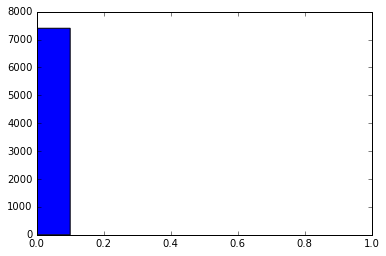

In [20]:
plt.hist(results[:,2],bins=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

In [21]:
m.predict_proba(input_fn=lambda: input_fn(df_test))

Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.


array([[  9.99792159e-01,   1.03926235e-04,   1.03886006e-04],
       [  9.99044478e-01,   4.96819674e-04,   4.58611001e-04],
       [  9.94100273e-01,   3.00260261e-03,   2.89707701e-03],
       ..., 
       [  9.99884129e-01,   6.07577022e-05,   5.50386139e-05],
       [  9.99555767e-01,   2.27925731e-04,   2.16213928e-04],
       [  9.99590933e-01,   2.27287543e-04,   1.81858646e-04]], dtype=float32)